In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys

In [2]:
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np
from lifelines.datasets import load_rossi


In [3]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)
data_GAN = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival_2.csv'),
                  index_col=None)

data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]

data_GAN_x = data_GAN.iloc[:, 2:]
data_GAN_y = data_GAN.iloc[:, 0:2]

# Lifetime

Text(0.5, 1.0, 'Failure at $cycle=1e6$')

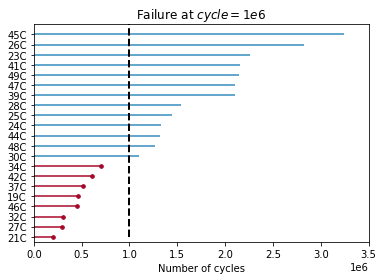

In [6]:
from lifelines.plotting import plot_lifetimes

current_time = 1000000

observed_lifetimes = np.minimum(data['F_Time'], current_time)
death_observed = data['F_Time'] < current_time

ax = plot_lifetimes(data['F_Time'], event_observed=death_observed)

ax.set_xlim(0, 3500000)
ax.vlines(1000000, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("Number of cycles")
ax.set_title("Failure at $cycle=1e6$")

# Kaplan Meier

## with original data

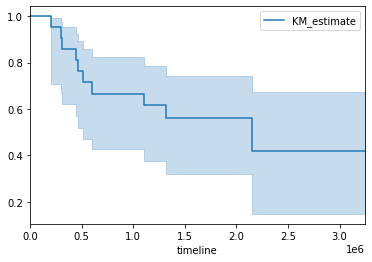

In [7]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(data_y["F_Time"], event_observed = data_y["Observed"])
kmf.plot()

## with GAN data

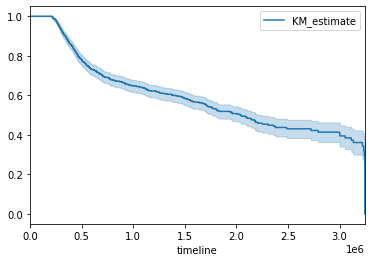

In [8]:
kmf = KaplanMeierFitter()
kmf.fit(data_GAN_y["F_Time"], event_observed = data_GAN_y["Observed"])
kmf.plot()

# Kaplan Meier by cycle at NDE

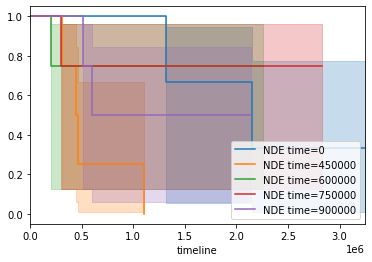

In [9]:
for age in [0, 450000, 600000, 750000, 900000]:
    mask_treat = data_x['NDE_cycle'] == age
    kmf.fit(data_y["F_Time"][mask_treat], event_observed = data_y["Observed"][mask_treat], label=f'NDE time={age}')
    ax = kmf.plot()

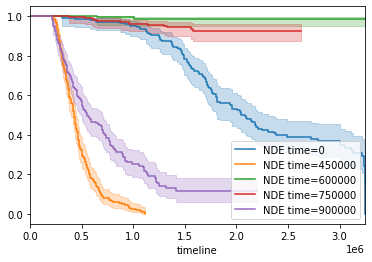

In [10]:
for age in [0, 450000, 600000, 750000, 900000]:
    mask_treat = data_GAN_x['NDE_cycle'] == age
    kmf.fit(data_GAN_y["F_Time"][mask_treat], event_observed = data_GAN_y["Observed"][mask_treat], label=f'NDE time={age}')
    ax = kmf.plot()

# CoxPH regression

## with real data

/Users/peerapon/opt/anaconda3/envs/epri_mc/lib/python3.8/site-packages/lifelines/utils/__init__.py:1094: ConvergenceWarning: Column(s) ['pos_ratio'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/peerapon/opt/anaconda3/envs/epri_mc/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1579: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


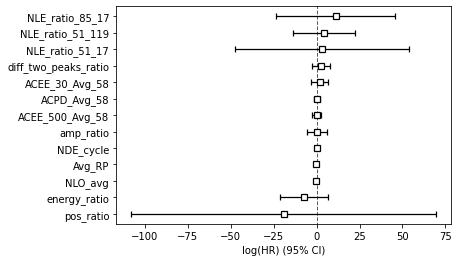

In [11]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(data, duration_col='F_Time', event_col='Observed')
cph.plot()

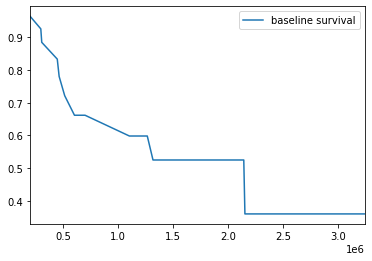

In [12]:
cph.baseline_survival_.plot()

## with GAN data

/Users/peerapon/opt/anaconda3/envs/epri_mc/lib/python3.8/site-packages/lifelines/utils/__init__.py:1094: ConvergenceWarning: Column(s) ['pos_ratio'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


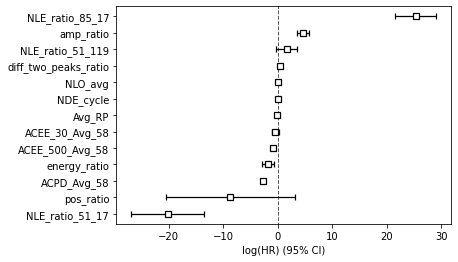

In [13]:
cph.fit(data_GAN, duration_col='F_Time', event_col='Observed')
cph.plot()

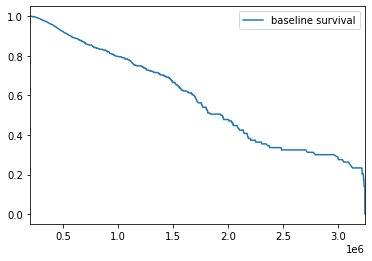

In [14]:
cph.baseline_survival_.plot()

# Weibull AFT

In [15]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    data_GAN, test_size=0.25)

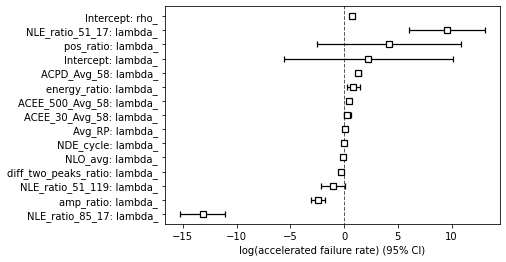

In [16]:
from lifelines import WeibullAFTFitter

weib = WeibullAFTFitter()
weib.fit(df_train, duration_col='F_Time', event_col='Observed')
weib.plot()

In [17]:
surv = weib.predict_survival_function(df_test)

In [18]:
df_test.columns

Index(['Observed', 'F_Time', 'NDE_cycle', 'diff_two_peaks_ratio', 'amp_ratio',
       'pos_ratio', 'energy_ratio', 'NLE_ratio_51_17', 'NLE_ratio_85_17',
       'NLE_ratio_51_119', 'NLO_avg', 'Avg_RP', 'ACEE_30_Avg_58',
       'ACEE_500_Avg_58', 'ACPD_Avg_58'],
      dtype='object')

In [19]:
df_test.shape

(250, 15)

In [20]:
surv.columns

Int64Index([964,  23, 644, 470, 228, 866, 346, 260, 497, 988,
            ...
            223, 808, 253, 914, 366, 967, 916, 379, 652, 183],
           dtype='int64', length=250)

In [37]:
weib.score(df_train, scoring_method='concordance_index')

0.8881626851673861

In [21]:
weib.score(df_test, scoring_method='concordance_index')

0.8929783909037021

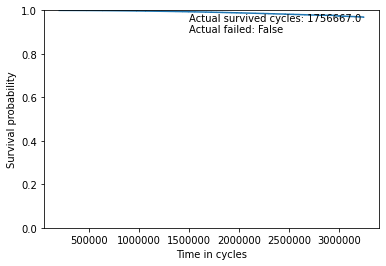

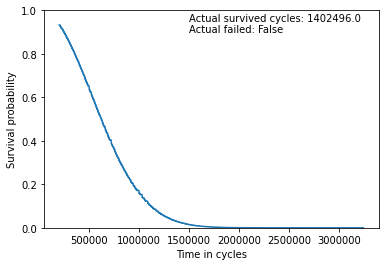

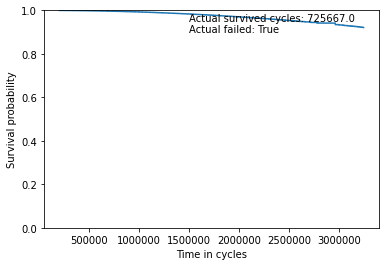

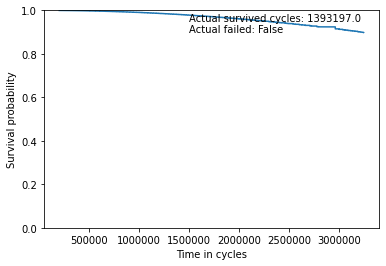

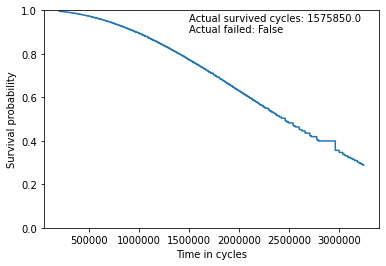

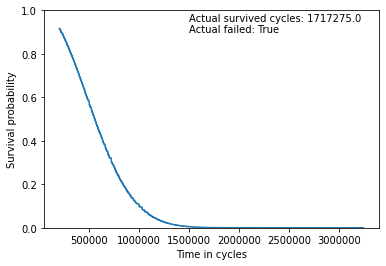

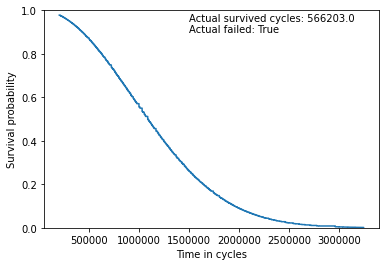

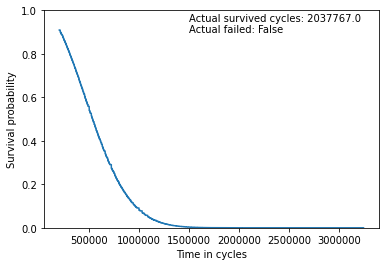

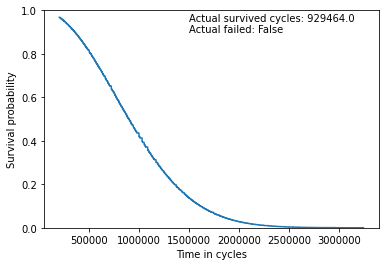

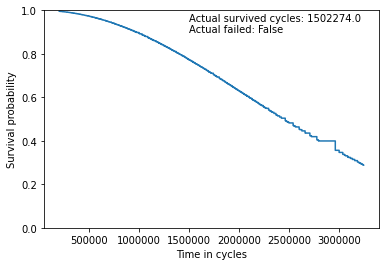

In [39]:
for i in range(0, 10):
    col = surv.columns[i]
    plt.step(surv.index, surv[col], where="post")
    plt.ylabel("Survival probability")
    plt.xlabel("Time in cycles")
    plt.ticklabel_format(style='plain')
    plt.ylim(0,1)
    plt.text(1500000, 0.95, 'Actual survived cycles: '+str(np.round(df_test['F_Time'].iloc[i],0)))
    plt.text(1500000, 0.90, 'Actual failed: '+str((df_test['Observed'].iloc[i])))
    plt.show()

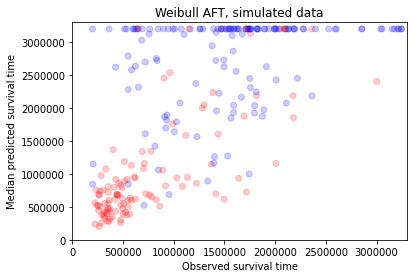

In [55]:
median_surv = weib.predict_median(df_test)
median_survival_list = np.clip(median_surv, 0, 3200000).tolist()
colordict = {False:'blue', True:'red'}
plt.scatter(x=df_test['F_Time'],y=median_survival_list,c=[colordict[c] for c in df_test['Observed']],alpha=0.2)
plt.ticklabel_format(style='plain')
plt.xlim([0, 3300000])
plt.ylim([0, 3300000])
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Weibull AFT, simulated data")
plt.show()

## real data

In [115]:
data.shape

(21, 15)

In [119]:
weib.score(data, scoring_method='concordance_index')

0.8263888888888888

0.8402777777777778


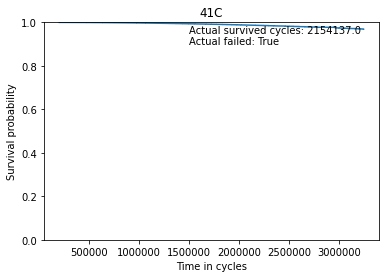

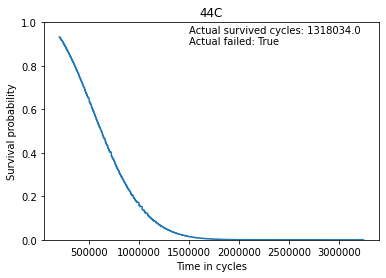

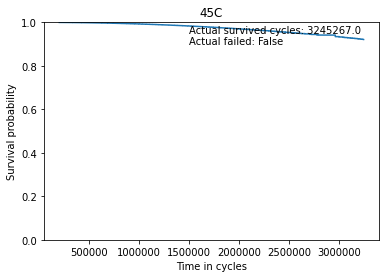

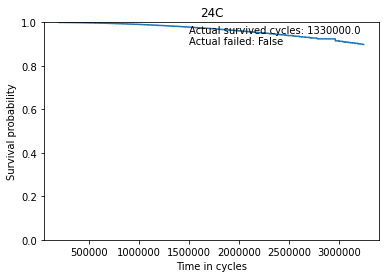

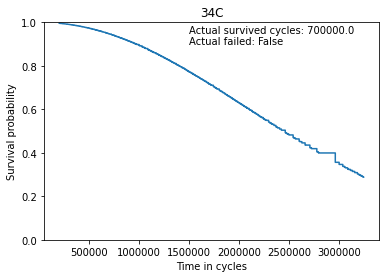

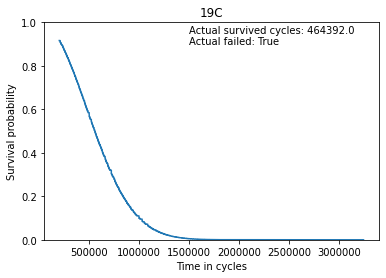

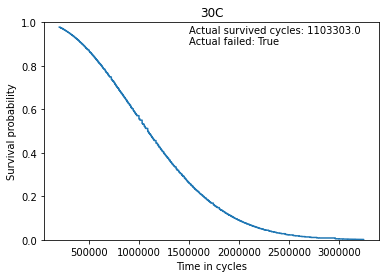

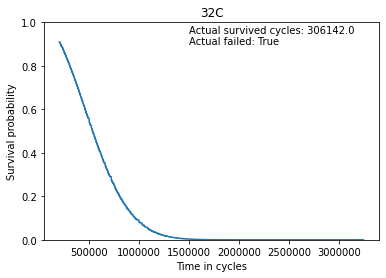

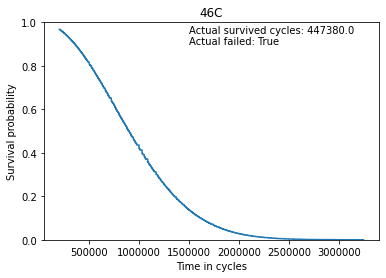

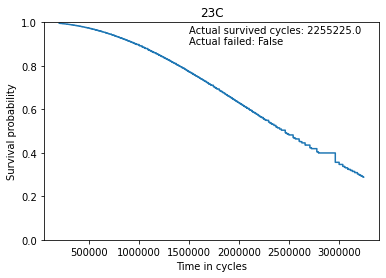

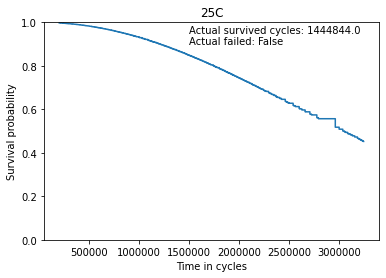

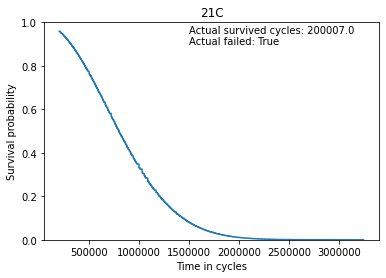

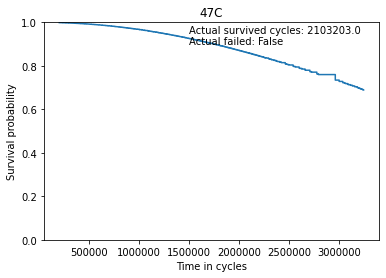

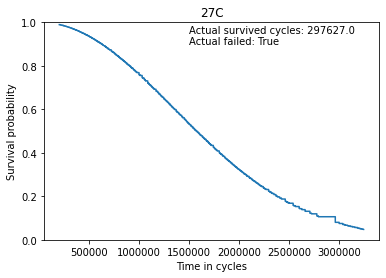

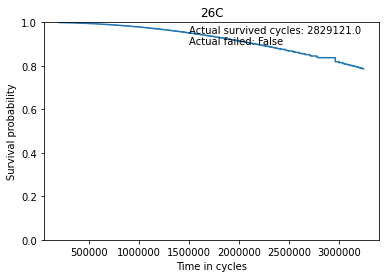

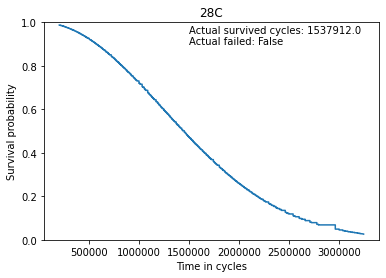

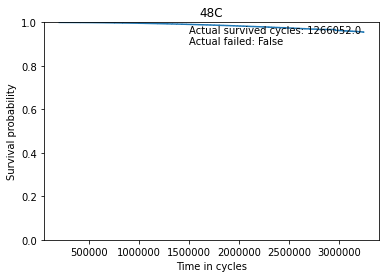

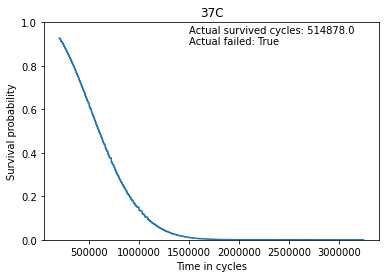

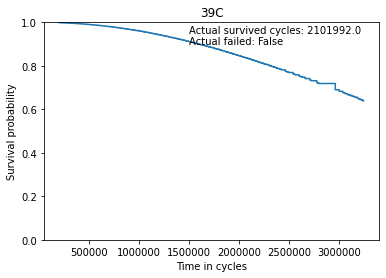

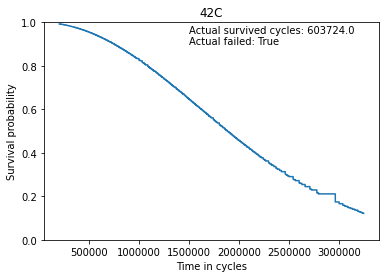

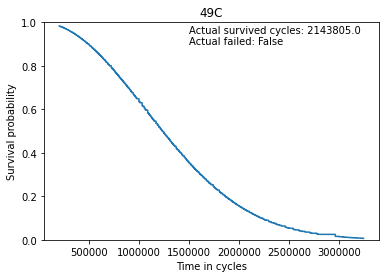

In [40]:
print(weib.score(data, scoring_method='concordance_index'))

surv = weib.predict_survival_function(data)

for i in data.index:
    col = i
    plt.step(surv.index, surv[col], where="post")
    plt.ylabel("Survival probability")
    plt.xlabel("Time in cycles")
    plt.ticklabel_format(style='plain')
    plt.ylim(0,1)
    plt.text(1500000, 0.95, 'Actual survived cycles: '+str(np.round(data['F_Time'].loc[i],0)))
    plt.text(1500000, 0.90, 'Actual failed: '+str((data['Observed'].loc[i])))
    plt.title(i)
    plt.show()
    
    

In [79]:
weib.params_

param    covariate           
lambda_  ACEE_30_Avg_58           0.178713
         ACEE_500_Avg_58          0.478853
         ACPD_Avg_58              1.380967
         Avg_RP                   0.080124
         NDE_cycle                0.000001
         NLE_ratio_51_119        -0.179013
         NLE_ratio_51_17         10.104968
         NLE_ratio_85_17        -12.952656
         NLO_avg                 -0.088031
         amp_ratio               -1.870794
         diff_two_peaks_ratio    -0.203505
         energy_ratio             0.597398
         pos_ratio                1.894208
         Intercept                2.054302
rho_     Intercept                0.781139
dtype: float64

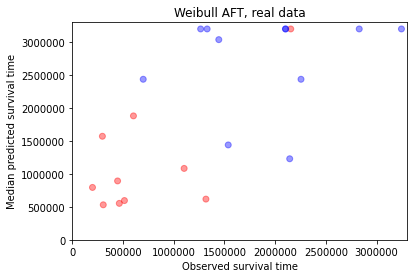

In [54]:
median_surv = weib.predict_median(data)
median_survival_list = np.clip(median_surv, 0, 3200000).tolist()
colordict = {False:'blue', True:'red'}
plt.scatter(x=data['F_Time'],y=median_survival_list,c=[colordict[c] for c in data['Observed']],alpha=0.4)
plt.ticklabel_format(style='plain')
plt.xlim([0, 3300000])
plt.ylim([0, 3300000])
plt.ylabel("Median predicted survival time")
plt.xlabel("Observed survival time")
plt.title("Weibull AFT, real data")
plt.show()